In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


Speech Command Classification with torchaudio
*********************************************

from [https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html](https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html)


This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
`torchaudio <https://github.com/pytorch/audio>`__ that can be installed
by following the instructions on the website.




In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
from src import *
from IPython.core.display import display
import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [3]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[1]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


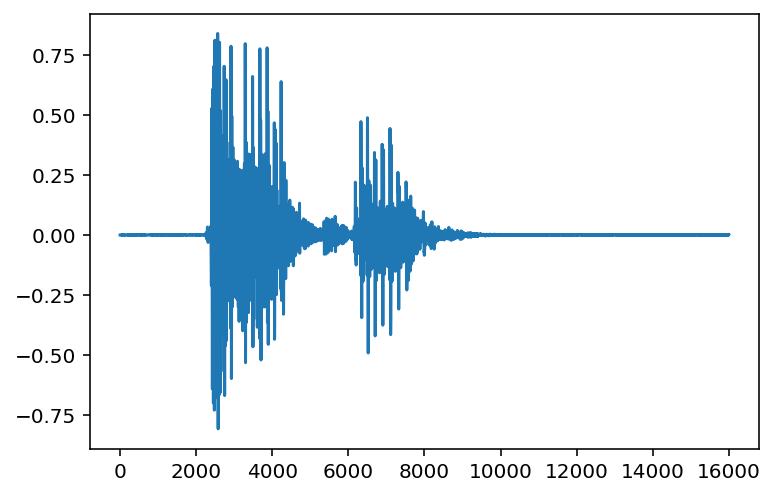

In [4]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [5]:
waveform[0, 10000:].abs().mean()

tensor(0.0005)

In [6]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

Let’s find the list of labels available in the dataset.




In [7]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))

Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [8]:
new_sample_rate = 16000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [9]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [10]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 128

num_workers = 4
pin_memory = True


train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




Training and Testing the Network
--------------------------------


In [11]:
def f(model, attack, n=1):
    w = 0
    for data in test_loader:
        x, y = map(lambda x: x.cuda(), data)
        model.train(False)
        adv = attack(model, x, y)
        pa = model(adv)
        p = model(x)
        for ind in range(x.size(0)):
            if p[ind, :].argmax() != y[ind]:
                continue
            if w >= n:
                break
                
            w += 1
            fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)
            
            fig.patch.set_facecolor('white')
            fig.suptitle(f'{labels[y[ind].item()]}: {labels[model(x).argmax(axis=1)[ind].item()]} → {labels[model(adv).argmax(axis=1)[ind].item()]}')
            
            ax1.plot(x[ind, :, 0].cpu().t().numpy())
            ax1.set_title("original")
            
            ax2.plot(adv[ind, :, 0].cpu().t().numpy())
            ax2.set_title("adversarial")
            
            ax3.plot((adv-x)[ind, :, 0].cpu().t().numpy())
            ax3.set_title("noise")
            
            display(ipd.Audio(adv[ind, :, 0].cpu().numpy(), rate=new_sample_rate))
            display(ipd.Audio(x[ind, :, 0].cpu().numpy(), rate=new_sample_rate))
            
            fig.show()
        if w >= n:
            break


In [25]:

            
class Block(nn.Module):
    def __init__(self, n_input, n_output, kernel_size, stride, p):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(n_input)
        self.bn2 = nn.BatchNorm1d(n_output)
        
        self.dropout = nn.Dropout(p)
        
        self.conv1 = nn.Conv1d(n_input, n_output, kernel_size=kernel_size, padding=(kernel_size // 2), stride=stride)
        self.conv2 = nn.Conv1d(n_output, n_output, kernel_size=kernel_size, padding='same', stride=1)
        
        self.conv_res = nn.Conv1d(n_input, n_output, kernel_size=1, padding=2 if stride > 1 else 0, stride=stride)
    def forward(self, x):
        x_out = F.relu(self.bn1(x))
        # print(x_out.shape)
        out = (self.dropout(F.relu(self.bn2(self.conv1(x_out)))))
        # print(out.shape)
        out = self.conv2(out)
        # print(out.shape)
        x_out = self.conv_res(x_out)
        # print(x_out.shape)
        return torch.add(x_out, out)
        
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32, p=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        # self.conv1 = Block(n_input, n_channel, kernel_size=80, stride=stride, p=p)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = Block(n_channel, n_channel, kernel_size=3, stride=1, p=p)
        self.pool2 = nn.MaxPool1d(4)
        
        self.conv3 = Block(n_channel, 2 * n_channel, kernel_size=3, stride=1, p=p)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)
        self.dropout = nn.Dropout(p=p)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x.squeeze()

torch.cuda.empty_cache()
from collections import OrderedDict
def mk_model(ϵ, K = 1, lr=0.1, weight_decay=1e-5, p=0.3):
    model = M5(p=p)
    if ϵ not in [0, False]:
        adv = AdversarialForFree(ϵ, -1, 1)
        l = [('adv', adv)]
    else:
        l = []
    l.extend([('model', model)])
    model = nn.Sequential(OrderedDict(l)).cuda()
    optimizer = optim.SGD(model.parameters(), lr=lr, 
                          weight_decay=weight_decay, momentum=0.9, nesterov=True)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 5 // K, gamma=0.2)
    
    return model, optimizer, scheduler
# The transform needs to live on the same device as the model and the data.

transform = transform.cuda()
model = mk_model(2)[0].cuda()
for x, y in train_loader:
    print(model(x.cuda()).shape)
    break

torch.Size([128, 35])


In [13]:
EPOCH = 15
K = 30
ϵ = 0.002
ϵ_s = 2.5 * ϵ / K
attack = PGD(K, ϵ, ϵ_s, min=-1, max=1)
name = f'{K}-PGD'

In [14]:
logs = defaultdict(lambda : [])
model, optimizer, scheduler = mk_model(0, lr=0.1)
for epoch in range(EPOCH):
    logs['train'].append(train_with_replay(1, model, train_loader, optimizer, epoch))
    logs['test'].append(run_val(model, test_loader, epoch))
    
    scheduler.step()

normal_model = model

run_attacks(logs, [attack], [name], model, test_loader, epoch)

train 	 1: 1.7188 50.2% 5.8s
val 	 1: 0.7836 76.9% 0.8s
train 	 2: 0.8984 73.8% 5.7s
val 	 2: 0.5956 83.0% 0.9s
train 	 3: 0.7560 77.9% 5.8s
val 	 3: 0.5046 84.7% 0.9s
train 	 4: 0.6907 79.7% 5.7s
val 	 4: 0.4442 86.9% 0.8s
train 	 5: 0.6542 80.8% 5.7s
val 	 5: 0.4317 86.7% 0.8s
train 	 6: 0.5440 83.9% 5.8s
val 	 6: 0.3354 89.9% 0.8s
train 	 7: 0.5254 84.5% 5.7s
val 	 7: 0.3387 89.7% 0.8s
train 	 8: 0.5108 84.9% 5.8s
val 	 8: 0.3154 90.7% 0.8s
train 	 9: 0.5042 85.2% 5.7s
val 	 9: 0.3134 90.7% 0.8s
train 	 10: 0.4982 85.3% 5.8s
val 	 10: 0.3063 90.8% 0.8s
train 	 11: 0.4768 85.8% 5.7s
val 	 11: 0.2959 91.1% 0.8s
train 	 12: 0.4707 86.1% 5.8s
val 	 12: 0.2919 91.3% 0.8s
train 	 13: 0.4689 86.1% 5.7s
val 	 13: 0.2898 91.2% 0.8s
train 	 14: 0.4668 86.2% 5.7s
val 	 14: 0.2901 91.3% 0.8s
train 	 15: 0.4660 86.1% 5.7s
val 	 15: 0.2865 91.4% 0.8s
adv 30-PGD 			 15: 12.9565 3.2% 35.8s


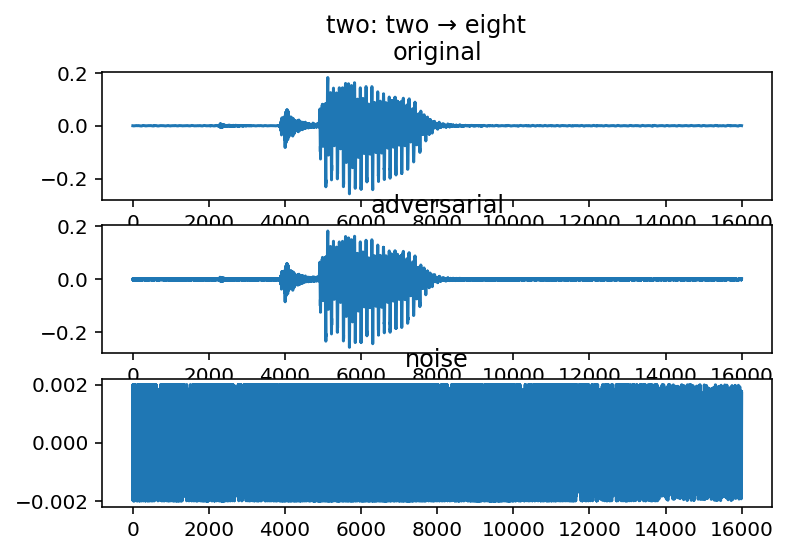

In [15]:
f(model, attack)

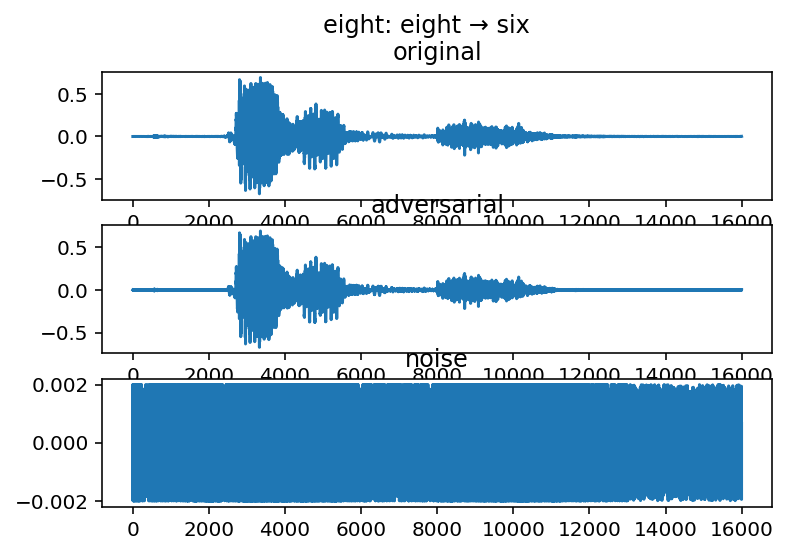

In [16]:
f(model, attack)

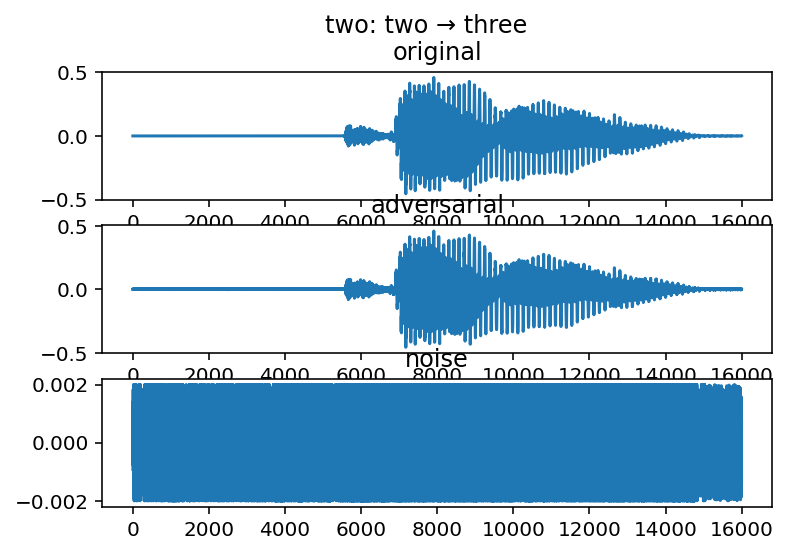

In [17]:
f(model, attack)

In [18]:
pgd_logs = defaultdict(lambda : defaultdict(lambda : []))
PGD_train_K = 1
train_attack = PGD(PGD_train_K, ϵ, 2.5 * ϵ / PGD_train_K, min=-1, max=1)
model, optimizer, scheduler = mk_model(0, 1, lr=0.1)
for epoch in range(EPOCH):
    pgd_logs[PGD_train_K]['train'].append(train_with_replay(1, 
      model, 
      train_loader, 
      optimizer, 
      epoch,
      input_func=lambda x, y: train_attack(model, x, y)))
    pgd_logs[PGD_train_K]['test'].append(run_val(model, test_loader, epoch))
    
    scheduler.step()

model_PGD = model

run_attacks(pgd_logs[PGD_train_K], [attack], [name], model, test_loader, epoch)

train 	 1: 2.1754 36.8% 15.8s
val 	 1: 1.1003 69.8% 0.9s
train 	 2: 1.4071 58.2% 15.8s
val 	 2: 0.7473 79.0% 0.8s
train 	 3: 1.2287 63.3% 15.8s
val 	 3: 0.6436 82.2% 0.8s
train 	 4: 1.1489 65.6% 15.8s
val 	 4: 0.6051 82.9% 0.8s
train 	 5: 1.1019 67.2% 15.8s
val 	 5: 0.5669 84.6% 0.9s
train 	 6: 0.9891 70.3% 15.8s
val 	 6: 0.4949 86.3% 1.0s
train 	 7: 0.9601 71.2% 15.8s
val 	 7: 0.4762 86.5% 0.8s
train 	 8: 0.9483 71.5% 15.8s
val 	 8: 0.4767 86.4% 0.8s
train 	 9: 0.9376 71.8% 15.8s
val 	 9: 0.4689 86.7% 0.8s
train 	 10: 0.9309 72.2% 15.8s
val 	 10: 0.4527 87.2% 0.9s
train 	 11: 0.9102 72.8% 15.9s
val 	 11: 0.4400 87.3% 0.8s
train 	 12: 0.8994 72.8% 15.8s
val 	 12: 0.4445 87.3% 0.8s
train 	 13: 0.8935 73.1% 15.8s
val 	 13: 0.4337 87.4% 0.8s
train 	 14: 0.8910 73.3% 15.8s
val 	 14: 0.4318 87.6% 0.8s
train 	 15: 0.8864 73.2% 15.9s
val 	 15: 0.4308 87.6% 0.8s
adv 30-PGD 			 15: 0.9367 70.1% 36.1s


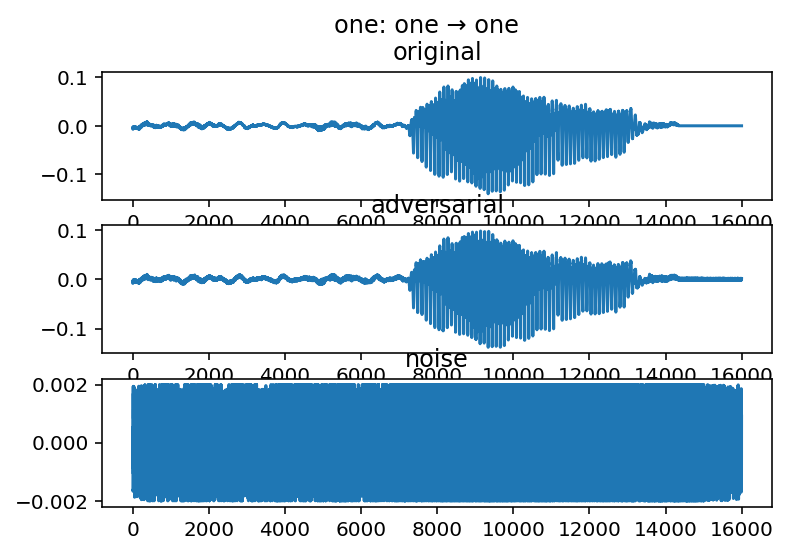

In [19]:
f(model, attack)

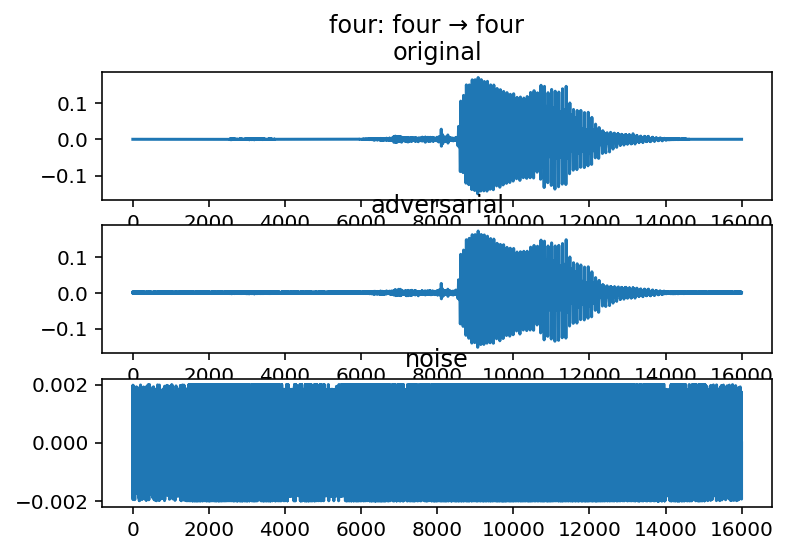

In [20]:
f(model, attack)

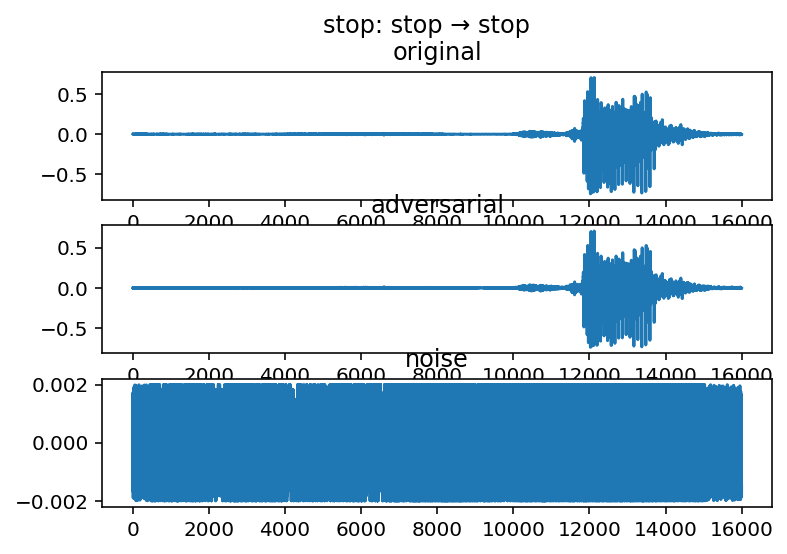

In [21]:
f(model, attack)

In [26]:
free_logs = defaultdict(lambda : defaultdict(lambda : []))
free_models = dict()
for p in [0, 0.3]:
    for K in [1, 5]:
        print(p, K, '\n\n\n\n')
        model, optimizer, scheduler = mk_model(ϵ, K=K, p=p)
        for epoch in range(EPOCH // K):
            free_logs[K]['train'].append(train_with_replay(K, model, train_loader, optimizer, epoch))
            free_logs[K]['test'].append(run_val(model, test_loader, epoch))
            run_attacks(free_logs[K], [attack], [name], model, test_loader, epoch)
            scheduler.step()

        free_models[(p, K)] = model


0 1 




train 	 1: 1.2217 64.6% 14.0s
val 	 1: 0.6941 79.3% 0.8s
adv 30-PGD 			 1: 8.2625 3.9% 35.7s
train 	 2: 0.5647 83.4% 14.0s
val 	 2: 0.7240 78.1% 0.8s
adv 30-PGD 			 2: 11.3365 2.5% 36.0s
train 	 3: 0.4594 86.5% 14.1s
val 	 3: 0.4103 87.7% 0.8s
adv 30-PGD 			 3: 13.4901 1.5% 36.1s
train 	 4: 0.4003 88.0% 14.1s
val 	 4: 0.4002 87.9% 0.8s
adv 30-PGD 			 4: 16.2341 1.1% 36.1s
train 	 5: 0.3652 89.1% 14.1s
val 	 5: 0.3579 89.0% 0.8s
adv 30-PGD 			 5: 14.4726 1.2% 36.1s
train 	 6: 0.2713 92.0% 14.1s
val 	 6: 0.2231 93.3% 0.9s
adv 30-PGD 			 6: 14.8046 1.6% 36.1s
train 	 7: 0.2532 92.5% 14.1s
val 	 7: 0.2161 93.5% 0.9s
adv 30-PGD 			 7: 16.5690 1.2% 36.1s
train 	 8: 0.2434 92.7% 14.1s
val 	 8: 0.2121 93.7% 0.9s
adv 30-PGD 			 8: 14.9185 1.4% 36.1s
train 	 9: 0.2378 92.9% 14.1s
val 	 9: 0.1966 94.0% 0.9s
adv 30-PGD 			 9: 17.0950 1.4% 36.1s
train 	 10: 0.2315 93.1% 14.1s
val 	 10: 0.2053 93.6% 0.8s
adv 30-PGD 			 10: 17.4742 1.3% 36.1s
train 	 11: 0.2110 93.7% 14.1s
val 	 11: 0.1751 9

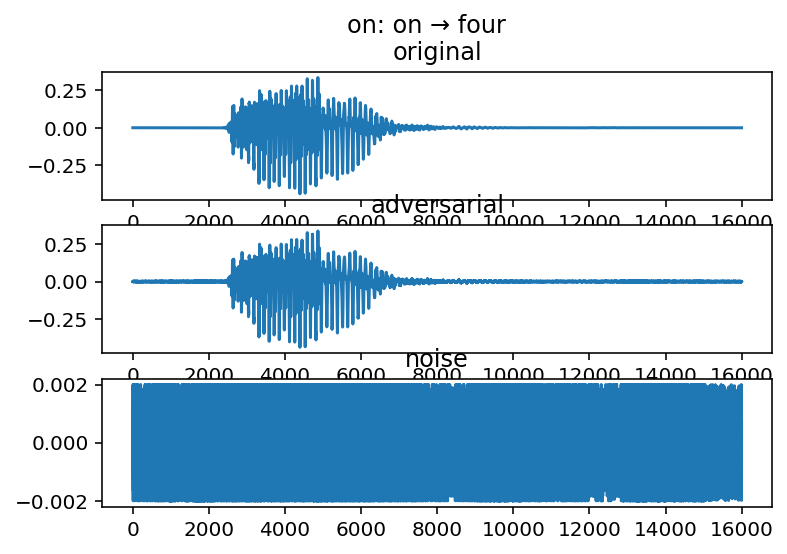

In [27]:
f(model, attack)

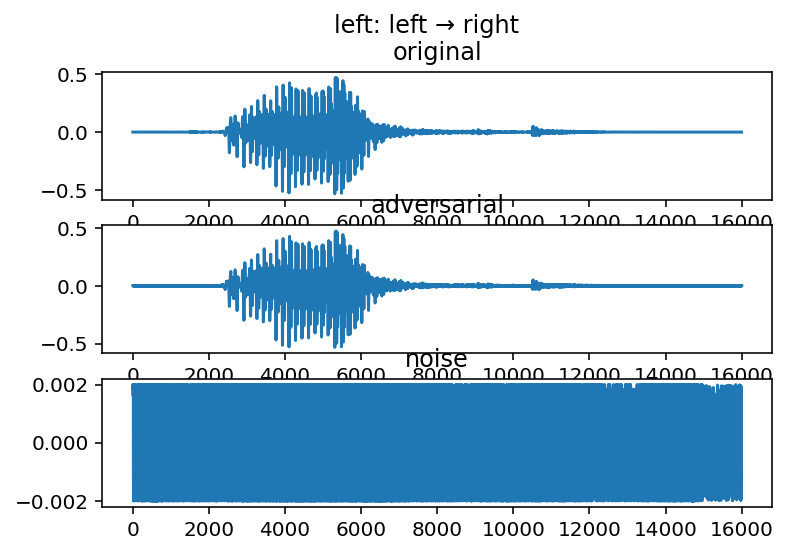

In [28]:
f(model, attack)

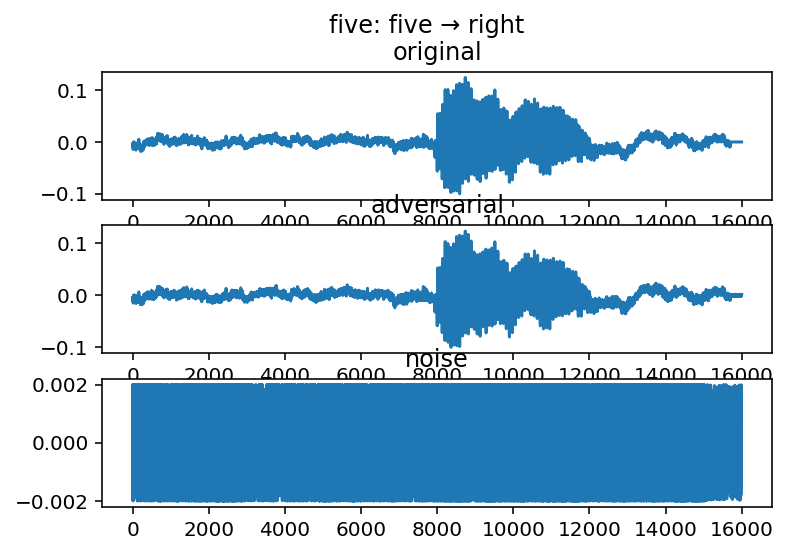

In [29]:
f(model, attack)